# Example_9_1

In [1]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/jdariasl/OTBD/main/content/init.py
import init; init.init(force_download=False)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import fmin_l_bfgs_b, minimize
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, RationalQuadratic, ExpSineSquared, Matern, WhiteKernel
from local.lib.BOutils import PI, EI, LCB, propose_location, plot_bo

In [3]:
#!sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended

We are going to define a toy problem to test Bayesian Optimisation on its most simple form.

In [4]:
def f(x):
    return (1 - np.tanh(x**2)) * np.sin(x*5)

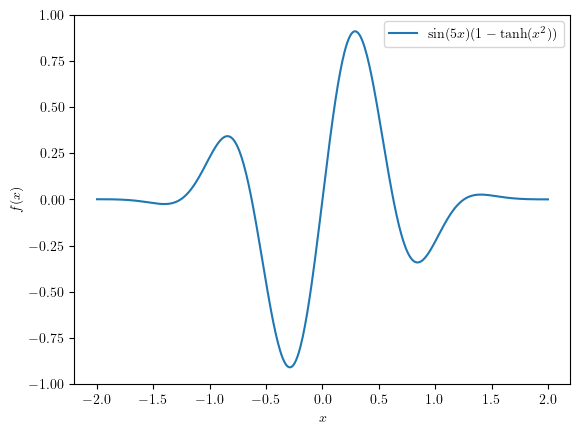

In [5]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

x = np.linspace(-2, 2, 400)[:, None]
_ = plt.plot(x, f(x), label=r"$\sin(5x)(1- \tanh(x^2))$")
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.legend(loc='best')

Suppose we have just some samples from this function and have to decide where to sample next:

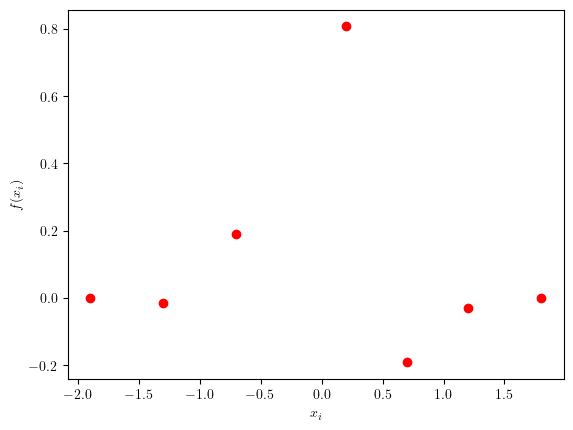

In [6]:
xi = np.array([-1.9, -1.3, -0.7, 0.2, 0.7, 1.2, 1.8])
noise = 0.05
yi = f(xi) #+ noise * np.random.randn(*xi.shape)
plt.plot(xi, yi, 'ro')
plt.xlabel("$x_i$")
_ = plt.ylabel("$f(x_i)$")

Let's train the surrogate model and see the resulting aquisition function:

/Users/julian/opt/anaconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


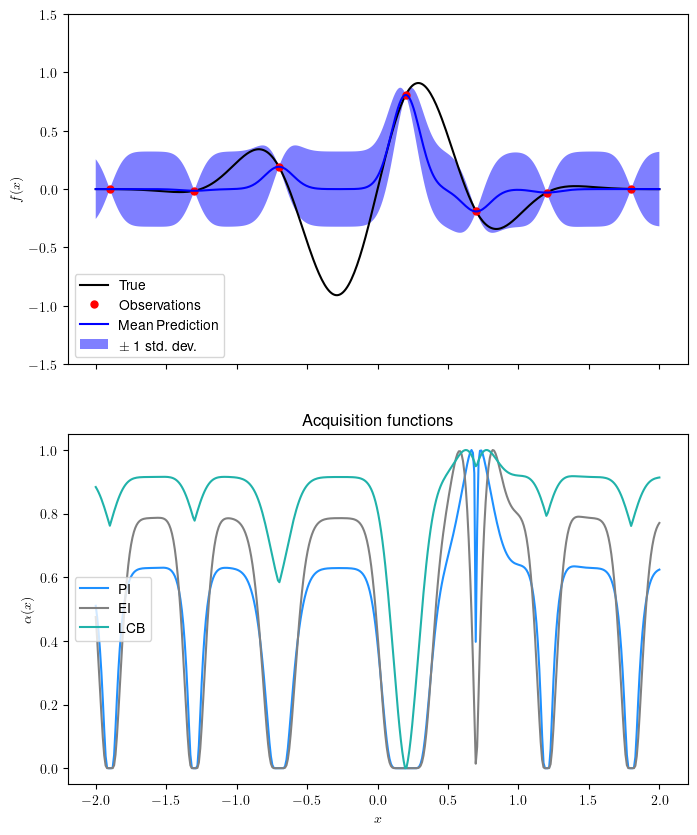

In [7]:
kernel = ConstantKernel() * RBF(length_scale=0.1, length_scale_bounds=(1e-1, 10.0)) 
k = 0
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20)
gp.fit(xi[:, None], yi)

x = np.linspace(-2, 2, 400)[:, None]
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,10),sharex='all')
plot_bo(ax1, ax2, x,f,xi,yi,gp)
plt.show()

There are plenty of resources about kernels; this [blog](https://peterroelants.github.io/posts/gaussian-process-kernels/) shows interesting examples.

Now let's see the next query point (**Run this cell multiple times to watch the evolution**):

Iteration=3


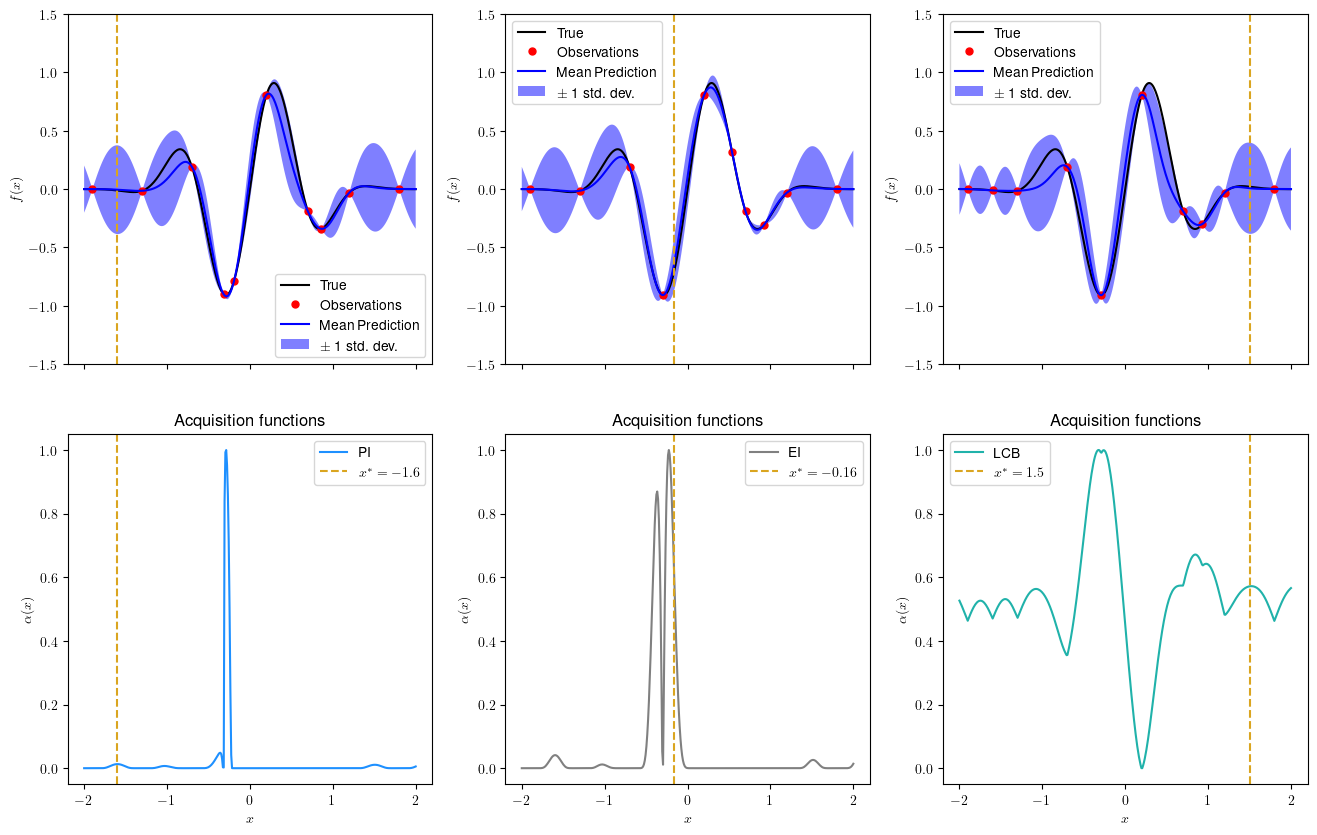

In [11]:
if k== 0:
    xi_pi = xi.copy(); yi_pi = yi.copy(); xi_ei = xi.copy(); yi_ei = yi.copy(); xi_lcb = xi.copy(); yi_lcb = yi.copy()
    gp_pi = gp; gp_ei = gp; gp_lcb = gp 

e = 0.5*np.exp(-0.1*k)    
next_pi = propose_location(PI,xi_pi[:, None],gp_pi, np.array([[-2, 2]]),epsilon=e)
next_ei = propose_location(EI,xi_ei[:, None],gp_ei, np.array([[-2, 2]]), epsilon=e)
next_lcb = propose_location(LCB,xi_lcb[:, None],gp_lcb, np.array([[-2, 2]]),epsilon=20*e)
print(f'Iteration={k}')
fig, ax = plt.subplots(2,3, figsize=(16,10),sharex='all')
plot_bo(ax[0,0], ax[1,0], x,f,xi_pi,yi_pi,gp_pi,next_pi,ad='PI')
plot_bo(ax[0,1], ax[1,1], x,f,xi_ei,yi_ei,gp_ei,next_ei, ad='EI')
plot_bo(ax[0,2], ax[1,2], x,f,xi_lcb,yi_lcb,gp_lcb,next_lcb, ad= 'LCB')
plt.show()


xi_pi = np.concatenate([xi_pi,next_pi[0]]); yi_pi = f(xi_pi)
xi_ei = np.concatenate([xi_ei,next_ei[0]]); yi_ei = f(xi_ei)
xi_lcb = np.concatenate([xi_lcb,next_lcb[0]]); yi_lcb = f(xi_lcb)

gp_pi = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20)
gp_pi.fit(xi_pi[:, None], yi_pi)
gp_ei = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20)
gp_ei.fit(xi_ei[:, None], yi_ei)
gp_lcb = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20)
gp_lcb.fit(xi_lcb[:, None], yi_lcb)
k += 1